
# Kaggle challenge - State Farm Distracted Driver detection #
Nepp & Dumhart


## Dataset ##

- 102k files ( labeled images of drivers )

- 10 classes

- raw colored images 

---

## 1. Imports & Versions ##


In [1]:

import cv2
import numpy as np
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import random
import os, os.path
import pandas as pd
import tensorflow as tf

import keras
from keras.utils.vis_utils import plot_model
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from keras.layers import Activation
from keras.layers import BatchNormalization

from sklearn.model_selection import train_test_split

print('Keras version:',keras.__version__) # Expects: 2.4.3
print('Tensorflow version:',tf.__version__) # Expects: 2.3.1

    

Keras version: 2.4.3
Tensorflow version: 2.3.1


## 1.1 - Utility ##

In [2]:

def display_array(array):
    if len(array.shape) > 2: # Check whether image is colored
        array = cv2.cvtColor(array.astype("uint8"), cv2.COLOR_BGR2RGB) # Swap BGR to RGB
    pil_img = Image.fromarray(array)
    display(pil_img)
    
# printing:

def pretty_print(thing, indent=0):  
    if isinstance(thing, list): 
        for e in thing:
            print(('   '*indent)+'[')
            pretty_print(e, indent=indent+1)
            print(('   '*indent)+']')
    elif isinstance(thing, dict): 
        for key, value in thing.items():
            print(('   '*indent)+str(key),': {')
            pretty_print(value, indent=indent+1)
            print(('   '*indent)+'}')
    else :
        print(('   '*indent)+str(thing))
        

---

## 2. Preprocessing ##

- Line Detection & Resizing

In [3]:

def line_detection( image ) :
    # Creating a custom line filter :
    line_filter = np.array([[-1, -2, -1], 
                            [ 0,  0,  0], 
                            [ 1,  2,  1]])
    stage_1 = ((cv2.filter2D(image, -1, line_filter) + cv2.filter2D(image, -1, line_filter.T))/2).astype(np.uint8)
    
    # New mirrored line filter :
    line_filter = np.array([[  1,   2,   1], 
                            [  0,   0,   0], 
                            [ -1,  -2,  -1]])
    stage_2 = ((cv2.filter2D(image, -1, line_filter) + cv2.filter2D(image, -1, line_filter.T))/2).astype(np.uint8)
    
    image = np.maximum(stage_1,stage_2)
    image = (255 * (image / image.max()))
    return image.astype(np.uint8)

def greyed_blured_and_line_detection( image, advanced=False, do_line_detection=True ) :
    # Remove color :
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Blur :
    if do_line_detection : blured = cv2.GaussianBlur(image,(5, 5), 0)
    
    if not advanced or not do_line_detection :
        if do_line_detection: return line_detection(blured)
        else : return image
    else :
        image = line_detection( image )
        blured = line_detection( blured )
        very_blured = cv2.GaussianBlur(image,(11, 11), 0)
        return  np.maximum(
                line_detection(very_blured), 
                np.maximum(image,blured).astype(np.uint8)).astype(np.uint8)

        #np.maximum(image,blured).astype(np.uint8)
    
   
def preprocess_image(img, advanced=False, do_line_detection=True, image_shape=None, flatten=True) :
    img = greyed_blured_and_line_detection(img, advanced=advanced, do_line_detection=do_line_detection)
    #print('After norm :',img)
    if image_shape is not None : img = cv2.resize(img,(image_shape[1],image_shape[0]))
    #print('After resize :', img)
    if flatten : img = img.flatten()
    
    return img


test_img = cv2.imread("data/imgs/test/img_2.jpg")
test_img = preprocess_image(test_img, image_shape=(128, 96), flatten=False)
print(test_img.shape)

# Let's test the preprocessing suite first :  
test_img = cv2.imread("data/imgs/test/img_2.jpg")
test_img = preprocess_image(test_img)
assert test_img.shape == (307200,)
print(test_img)
assert str(test_img) == '[ 0  2  4 ... 18  4  0]'
test_img = cv2.imread("data/imgs/test/img_2.jpg")
test_img = preprocess_image(test_img, flatten=False)
assert test_img.shape == (480, 640) 
del test_img
#------------------------------------------------------------------------------------------------------

(128, 96)
[ 0  2  4 ... 18  4  0]


### ... let's see what the preprocessor can do! : ###

(480, 640, 3)


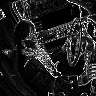

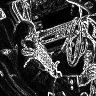

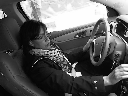

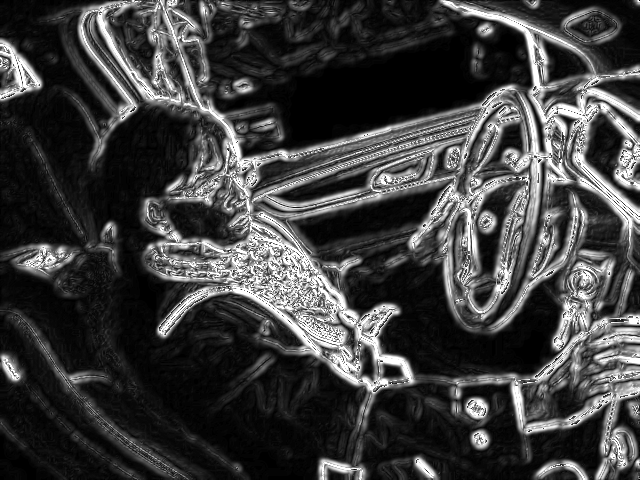

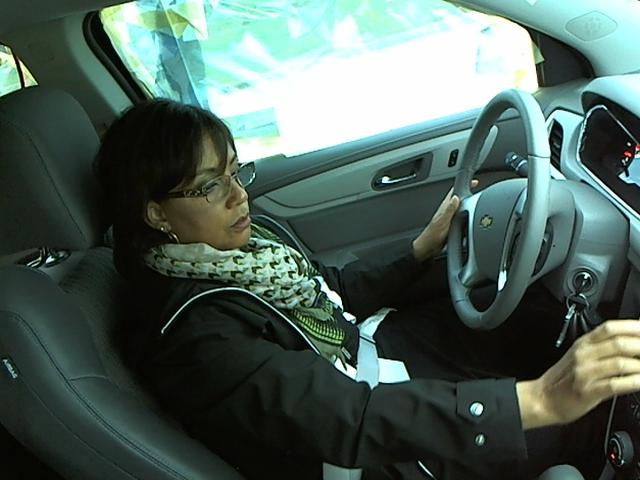

In [4]:
  
print(cv2.imread("data/imgs/test/img_1.jpg").shape)
    
# Converting to grayscale
display_array(
    cv2.resize(
    greyed_blured_and_line_detection( 
        cv2.imread("data/imgs/test/img_1.jpg"), advanced=False
    ),(96, 96))
)
display_array(
    cv2.resize(
    greyed_blured_and_line_detection( 
        cv2.imread("data/imgs/test/img_1.jpg"), advanced=True
    ),(96, 96))
)
display_array(
    cv2.resize(
    greyed_blured_and_line_detection( 
        cv2.imread("data/imgs/test/img_1.jpg"), advanced=True, do_line_detection=False
    ),(128, 96))
)

img = greyed_blured_and_line_detection( 
        cv2.imread("data/imgs/test/img_1.jpg"), advanced=True
    )
display_array(
    (255 * (img / img.max())).astype("uint8")
)
   
    
display_array(
    cv2.imread("data/imgs/test/img_1.jpg") 
)




---

## 3. Data Exploration ##

The classes with their meaning as keys! (used for plotting the distribution)


In [5]:

class_meaning_map = {
    'c0': 'Safe driving', 
    'c1': 'Texting - right', 
    'c2': 'Talking on the phone - right', 
    'c3': 'Texting - left', 
    'c4': 'Talking on the phone - left', 
    'c5': 'Operating the radio', 
    'c6': 'Drinking', 
    'c7': 'Reaching behind', 
    'c8': 'Hair and makeup', 
    'c9': 'Talking to passenger'
}



A utility method returning the number of files in a directory...

In [6]:
# This method returns the number of files at a given relative path.
def files_in_dir(file_path) :
    # simple version for working with CWD 
    # https://stackoverflow.com/questions/2632205/how-to-count-the-number-of-files-in-a-directory-using-python
    return len([name for name in os.listdir(file_path)]) 

assert files_in_dir("./data/imgs/test/") == 79726


The following method creates a simple mapping between the class names, <br>
which is also the directory names,
and the number of images within the given directory of a class.

In [7]:

# This method generates a ditionary of class names and the number of instances.
def create_class_data_map(path) :
    directories = os.listdir(path)
    class_data_map = dict()
    for c in directories : class_data_map[c] = files_in_dir(path+"/"+c)
    return class_data_map
    
# Testing the above :  
assert str(create_class_data_map("./data/imgs/")) == "{'test': 79726, 'train': 10}"


AssertionError: 

### Let's take a look at the class distribution! ###

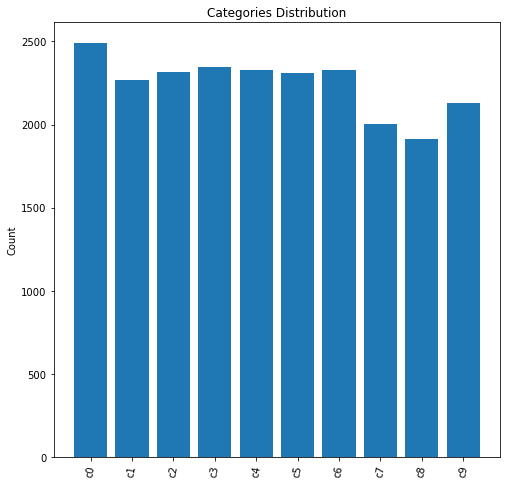

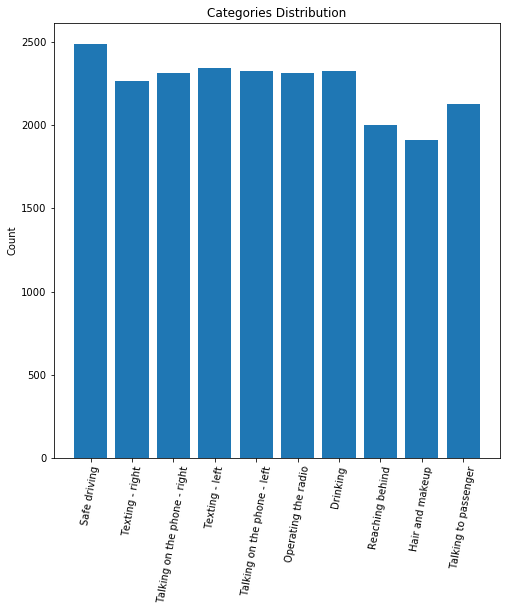

In [8]:

# Count the number of images per category
#sns.countplot(x = 'classname', data = dataset)

def plot_class_distribution( path, do_meaningful_label=False ):
    if do_meaningful_label :
        d, D = create_class_data_map(path), dict() 
        for c, count in d.items() : D[class_meaning_map[c]] = count
    else :
        D = create_class_data_map(path)
        
    plt.figure(figsize = (8,8))# Plot figure size
    plt.bar(range(len(D)), list(D.values()), align='center')
    plt.xticks(range(len(D)), list(D.keys()), rotation=80)
    plt.ylabel('Count')
    plt.title('Categories Distribution')
    plt.show()
    
plot_class_distribution("./data/imgs/train/", do_meaningful_label=False)
plot_class_distribution("./data/imgs/train/", do_meaningful_label=True)


### Let's see what those classes and their images look like! ###

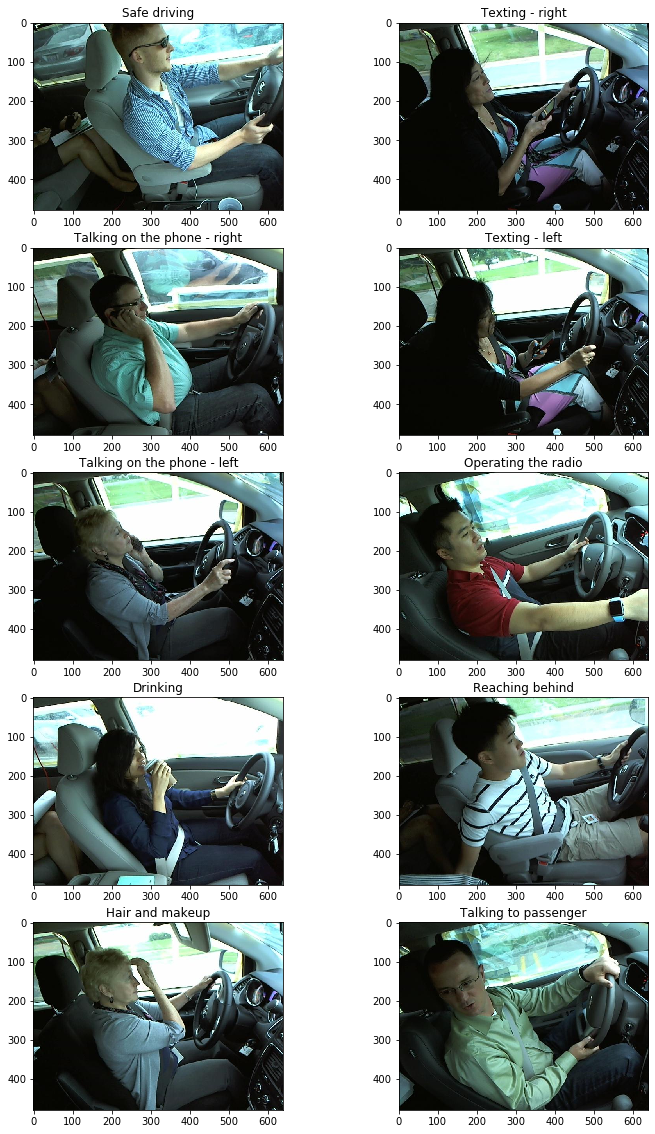

In [9]:
def plot_some_images(do_preprocessing=False):
    plt.figure(figsize = (12, 20))
    image_count = 1
    BASE_URL = './data/imgs/train/'
    for directory in os.listdir(BASE_URL):
        if directory[0] != '.':
            for i, file in enumerate(os.listdir(BASE_URL + directory)):
                if i == 1:
                    break
                else:
                    fig = plt.subplot(5, 2, image_count)
                    image_count += 1
                    image = cv2.imread(BASE_URL + directory + '/' + file)
                    if do_preprocessing : image = greyed_blured_and_line_detection(image, advanced=True)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Swap BGR to RGB
                    #display_array(image)
                    plt.imshow(image)
                    plt.title(class_meaning_map[directory])
                 
                
plot_some_images(do_preprocessing=False)

### Let's look at them after having applied some preprocessing! ###

In [ ]:

plot_some_images(do_preprocessing=True)

Seems promising! :)

---

## 4. Data Augmentation  ##

- More of the same but different!

Defined below is a simple method which takes 
lists of image arrays and label arrays and returns 
those lists containing 4 times as many labeled instances. <br>
This is because every image will also be added 3 more times 
with a random rotation applied to it. ( +/- 25° ) <br>


In [49]:
# I think we need more data... More space invariance...

def augment_data(X_train, y_train):
    """Generate synthetic images by simple transformations. 
    Size is the number of samples to be returned.  If size is set to zero, the same number 
    as input images is returned."""
    
    size = len(X_train)#.shape[0]
    assert len(X_train) == len(y_train)#.shape[0]
    
    # Convert images to 2D
    images = X_train#[image.reshape(image_shape) for image in X_train]
    labels = y_train
 
    # Create augmented images equal to size
    augmented_images = []
    new_labels = []
    for i in range(size):
        augmented_images.append(images[i])
        new_labels.append(labels[i])
        rotation_ranges = [(-25,-7),(7, 25)]
        for r in rotation_ranges:
            #--- 
            img = images[i]
            # Rotate image with random parameters
            rows,cols = img.shape[:2]
            rot_matrix = cv2.getRotationMatrix2D(center=(cols/2, rows/2), 
                                                 angle=np.random.randint(r[0],r[1]), 
                                                 scale=1)
            img = cv2.warpAffine(img, rot_matrix, (cols,rows))
            # Add augmented image and corresponding labels to result containers
            augmented_images.append(img)
            new_labels.append(labels[i])
            #---
 
    return np.array(augmented_images), np.array(new_labels)


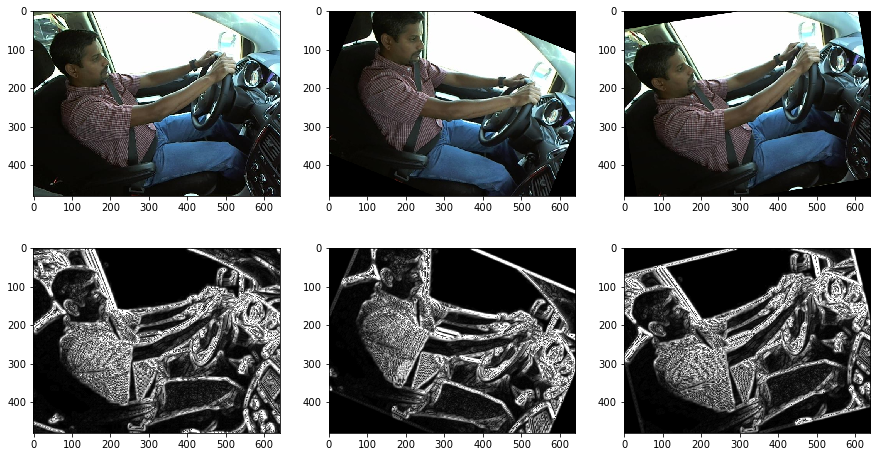

In [11]:

some_image = cv2.imread('./data/imgs/train/c0/img_34.jpg')

augmented, labeled = augment_data([some_image, some_image], ["I am a summy label :)", "Me too!"])

plt.figure(figsize = (15,8)) 
image_count = 1
for img in augmented :
    #display_array(img)
    fig = plt.subplot(2, 3, image_count)
    image_count += 1 
    if image_count > 4 : img = greyed_blured_and_line_detection(img, advanced=True)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Swap BGR to RGB
    #display_array(image)
    plt.imshow(img) 


---

## 5. Data Loading ##


In order to make our model, as well as data pipeline as 
configurable as possible <br> 
we create the option for multiple normalization techniques of our
input data below.

In [10]:
def norm(data, norm_type) :
    if norm_type == 'default' :
        return data / 255
    elif norm_type == 'mean_remove' : 
        return data - np.mean(data)
    elif norm_type == 'standard' :
        return ( data - np.mean(data) ) / np.std(data)
    elif norm_type == 'softmax' :
        e_x = np.exp(data - np.max(data))
        return e_x / e_x.sum()
    
    return data

Finally everything comes together! <br>
The following uses the previously defines methods for batch and label reading. <br>
It can optionally apply :

- normalization 
- one-hot encoding 
- linedetection
- advanced preprocessing (thourow line detection)
- custom resizing
- flattening

In [53]:
def load_data( 
    path, 
    class_picks, 
    size, 
    do_label_index_encoding=False, 
    advanced_preprocessing=False,
    do_line_detection=True,
    image_shape=None,
    flatten=True,
    normalization=None,
    create_augmented_imgs=False
) : 

    print('Loading data now... samples per class :',size,)
    filenames = []
    classes = []
    class_list = list(class_picks.keys())

    imgs_list = pd.read_csv("data/driver_imgs_list.csv")
    for c in class_list:
        class_imgs = imgs_list[imgs_list["classname"]==c]["img"].values
        np.random.shuffle(class_imgs)
        filenames.extend(class_imgs[:size:])
        classes.extend([c]*size)

    df = pd.DataFrame()
    df["filename"] = filenames
    df["class"] = classes
    df = df.sample(frac = 1)

    batch = []
    labels = []

    for index, row in df.iterrows():
        name = row['filename']
        c = row["class"]
        img = cv2.imread(path+"/"+c+"/"+name)
        img = preprocess_image(
            img, 
            advanced=advanced_preprocessing,
            do_line_detection=do_line_detection,
            image_shape=image_shape,
            flatten=flatten
        ) 
        img = norm(img, "default")

        label = None
        label_index = class_list.index(c)
        if do_label_index_encoding :
            label = label_index
        else :
            label = [0]*len(class_list)
            label[label_index] = 1
            label = np.array(label)
            
        batch.append(img)
        labels.append(label)
        
    if create_augmented_imgs :
        batch, labels = augment_data(batch, labels)
        
    random.Random(66642666).shuffle(batch)   
    random.Random(66642666).shuffle(labels)   

    return np.array(batch), np.array(labels)

#-----------------------------------------------
# Some Testing : 
     
b, l = load_data(
    "data/imgs/train", 
    create_class_data_map("data/imgs/train"),
    size=6,
    create_augmented_imgs=False
) 
    
assert b.shape == (60, 307200)
assert l.shape == (60, 10)  
 
b, l = load_data(
    "data/imgs/train", 
    create_class_data_map("data/imgs/train"),
    size=6, do_label_index_encoding=True,
    create_augmented_imgs=False
)


assert b.shape == (60, 307200)
assert l.shape == (60,)
    
b, l = load_data(
    "data/imgs/train", 
    create_class_data_map("data/imgs/train"),
    size=6, do_label_index_encoding=True, flatten=False,
    create_augmented_imgs=True
)
assert b.shape == (180, 480, 640)
assert l.shape == (180,)

b, l = load_data(
    "data/imgs/train", 
    create_class_data_map("data/imgs/train"),
    size=6, do_label_index_encoding=True, flatten=False,
    image_shape=(128, 96),
    create_augmented_imgs=True
)
 
assert b.shape == (180, 128, 96)
assert l.shape == (180,)

del b, l

Loading data now... samples per class : 6
Loading data now... samples per class : 6
Loading data now... samples per class : 6
Loading data now... samples per class : 6


In [56]:
b, l = load_data(
    "data/imgs/train", 
    create_class_data_map("data/imgs/train"),
    size=6, do_label_index_encoding=True, flatten=False,
    image_shape=(128, 96)
)
print(b, l)

Loading data now... samples per class : 6
[[[0.01568627 0.00784314 0.         ... 0.02352941 0.01568627 0.        ]
  [0.01568627 0.00392157 0.         ... 0.28235294 0.05098039 0.00784314]
  [0.01568627 0.01960784 0.01960784 ... 0.18431373 0.34117647 0.07058824]
  ...
  [0.03529412 0.03529412 0.12941176 ... 0.1254902  0.10588235 0.47058824]
  [0.07843137 0.18431373 0.10588235 ... 0.15294118 0.14117647 0.52156863]
  [0.03137255 0.22352941 0.05098039 ... 0.11764706 0.06666667 0.50196078]]

 [[0.00784314 0.         0.01176471 ... 0.2745098  0.23137255 0.        ]
  [0.01568627 0.         0.         ... 0.11764706 0.63137255 0.        ]
  [0.01960784 0.02745098 0.02745098 ... 0.1372549  0.6627451  0.        ]
  ...
  [0.47058824 0.71372549 0.13333333 ... 0.03921569 0.01960784 0.01568627]
  [0.28235294 0.54509804 0.41568627 ... 0.         0.02745098 0.03921569]
  [0.38039216 0.39607843 0.58823529 ... 0.03921569 0.02352941 0.05490196]]

 [[0.03137255 0.         0.         ... 0.04705882 0.3

---

## 5. The Model ##

First we define a custom activation function we wanted to test! <br>
The function is similar to relu but also very smooth.

In [66]:

def mish(x): return x * (K.tanh(K.softplus(x)))
get_custom_objects().update({'mish': Activation(mish)})


Here we load data to test independently of the trials.

In [62]:
samples_per_class=190
advanced_preprocessing=False
flatten=False
normalization="default"
    
    # Loading (and preprocessing) data :
preload_batch, preload_labels = load_data(
    "data/imgs/train", 
    create_class_data_map("data/imgs/train"), 
    size=samples_per_class, 
    #do_label_index_encoding=False, # This is too much for the NN
    advanced_preprocessing=advanced_preprocessing,
    image_shape=(96, 96),#(256, 192) #640 * 480
    flatten=flatten,
    normalization=normalization
)

Loading data now... samples per class : 190


In [63]:
print(preload_batch.shape, preload_labels.shape)

(1900, 96, 96) (1900, 10)


Now Let's define a method which represents a single trial. <br>
A trial consists of the creation of a model, loading (and preprocessing) 
training data, training the model and then evaluating it by loading
test data! <br>

In [70]:
def exec_trial(settings) :
    
    print('Starting trial with the following parameters : \n')
    pretty_print(settings)
    # Read settings:
    advanced_preprocessing = settings['advanced_preprocessing']
    do_conv = settings['convos'] != None
    flatten = not do_conv
    actifuns = settings['actifuns']
    layer_sizes = settings['layer_sizes']
    samples_per_class = settings['samples_per_class'] #:= 50
    normalization = settings['normalization']
    
    use_preload = settings['use_preload']
    
    if not use_preload:
        b, l = load_data(
            "data/imgs/train", 
            create_class_data_map("data/imgs/train"), 
            size=samples_per_class, 
            #do_label_index_encoding=True, # This is too much for the NN
            advanced_preprocessing=advanced_preprocessing,
            image_shape=(96, 96),#(256, 192) #640 * 480
            flatten=flatten,
            normalization=normalization
        )
    else:
        b,l = preload_batch, preload_labels
    
    train_batch, train_labels = b, l
   
    real_batch_size = train_batch.shape[0]
    train_batch, X_test, train_labels, y_test = train_test_split(train_batch, train_labels, train_size=0.8)
    
    #print(
    #    X_test.shape, y_test
    #)
    
    print('Input shape :', train_batch.shape, '; flatten : ', flatten, '; do_conv :', do_conv)
    print('Label shape :',train_labels.shape)
    # reshape for convolution:
    if do_conv : 
        train_batch = train_batch.reshape(list(train_batch.shape) + [1]) 
        print('Input shape for convolution:', train_batch.shape)
         
    input_dimension = train_batch.shape[1]
    input_shape = train_batch.shape
    output_dimension = 10#train_labels.shape[len(train_labels.shape)-1]

    print('Input dimension:',input_dimension,'; output_dimension:',output_dimension,';')
    #--------------------------------------------------------------
    model = keras.Sequential()
    if 'mish' in actifuns: model.add(Activation(mish, name='mish'))
    #--------------------------------------------------------------
 
    # CONVOLUTION ...  
    #~~~~~~~~~~~~~~~~
    if do_conv :
        first_iter_done = False
        for convo in settings['convos'] : 
            if 'value' in convo : value = convo['value']
            if convo['type'] == 'conv2d' : 
                if first_iter_done :
                    model.add(
                        keras.layers.Conv2D(
                            value['filters'], 
                            value['kernel_size'],  
                            activation=value['activation'],  
                            padding=value['padding']
                        )
                    )
                else :
                    model.add(
                        keras.layers.Conv2D(
                            value['filters'], 
                            value['kernel_size'], 
                            input_shape=(96, 96, 1),
                            activation=value['activation'],  
                            padding=value['padding']
                        )
                    )
            elif convo['type'] == 'maxpool' : 
                model.add(keras.layers.MaxPooling2D(pool_size=convo['value']['pool_size']))
            elif convo['type'] == 'avgpool' :
                model.add(keras.layers.AveragePooling2D(pool_size=convo['value']['pool_size']))
            elif convo['type'] == 'batch_norm' :
                model.add(BatchNormalization())
            else : print('Invalid configuration!!! Convolution type "', convo['type'],'" unknown!')
            first_iter_done = True
            model.add(keras.layers.Dropout(0.1))
        
        model.add(keras.layers.Flatten())
        start = 0
    else :  
        model.add(keras.layers.Dense(layer_sizes[0], input_dim=input_dimension, activation=actifuns[0]))
        start = 1
    
    # DENSE LAYERS :
    #~~~~~~~~~~~~~~
    for i in range(start, len(layer_sizes)) :
        print('Adding layer', i, 'with size ', layer_sizes[i], 'and activation', actifuns[i])
        model.add(keras.layers.Dense(layer_sizes[i], activation=actifuns[i]))
        model.add(keras.layers.Dropout(0.3))
        
    # OUTPUT LAYER :
    #~~~~~~~~~~~~~~~
    model.add(
        keras.layers.Dense(
            output_dimension, 
            activation="softmax"
        )
    )
    
    model.build(input_shape=train_batch.shape)

    # Create model
    #~~~~~~~~~~~~~~~
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss="categorical_crossentropy",#"categorical_crossentropy"
        metrics=["accuracy"]
    )
    print(model.summary())
    #plot_model(model)
    
    print('-----------------------------------------------------\nTraining now...')
    print('train_labels.shape=',train_labels.shape)
    print('train_batch.shape=',train_batch.shape)
    print('input_dimension=',input_dimension)
    print('output_dimension=',output_dimension)
    
    # Configure stopping criterion via early stopping
    callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=4)

    # Train model
    #~~~~~~~~~~~~~~~
    history_augmented = model.fit(
        train_batch, 
        train_labels,
        batch_size=samples_per_class*5,
        validation_split=0.2,
        epochs=20,
        callbacks=[callback],
        verbose=True
    )
    
    # reshape for convolution:
    if do_conv : 
        X_test = X_test.reshape(list(X_test.shape) + [1]) 
        print('Input shape for convolution:', train_batch.shape)
          
    # Test model :
    #~~~~~~~~~~~~~
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print('Done! Test-loss:', test_loss, '; Test-acc', test_acc, ';')
    return model


## Let's do some hyperparameter tuning : ##

In [71]:
trials = [
    #{
    #    'use_preload': True,
    #    'do_line_detection':False,
    #    'advanced_preprocessing':False,
    #    'normalization':'default',
    #    'actifuns' : ['relu'],
    #    'layer_sizes' : [55],
    #    'samples_per_class' : 190,
    #    'convos' : [ #64, (8,8), input_shape=(128, 96, 1),activation=hidden_acti,  padding="same"
    #        {
    #            'type':'conv2d', #128, (8, 8), activation="selu", padding="same"
    #            'value' : {
    #                'filters': 32,
    #                "kernel_size": (3,3),
    #                "activation" : "relu",
    #                "padding": "same"
    #            }
    #        },
    #        {'type':'batch_norm'},
    #        {
    #            'type':'conv2d', #128, (8, 8), activation="selu", padding="same"
    #            'value' : {
    #                'filters': 32,
    #                "kernel_size": (3,3),
    #                "activation" : "relu",
    #                "padding": "same"
    #            }
    #        },
    #        {'type':'batch_norm'},
    #        {
    #            'type':'maxpool', 
    #            'value' : {
    #                'pool_size': (2,2)
    #            }
    #        }
    #    ]
    #},
    {
        'use_preload': True,
        'do_line_detection':True,
        'advanced_preprocessing':True,
        'normalization':'standard',
        'actifuns' : ['mish', 'mish', 'mish'],
        'layer_sizes' : [],
        'samples_per_class' : 190,
        'convos' : [ #64, (8,8), input_shape=(128, 96, 1),activation=hidden_acti,  padding="same"
            {
                'type':'conv2d', #128, (8, 8), activation="selu", padding="same"
                'value' : {
                    'filters': 16,
                    "kernel_size": (3,3),
                    "activation" : "selu",
                    "padding": "same"
                }
            },
            {
                'type':'maxpool', 
                'value' : {
                    'pool_size': (3,3)
                }
            },
            {
                'type':'conv2d', #128, (8, 8), activation="selu", padding="same"
                'value' : {
                    'filters': 128,
                    "kernel_size": (3,3),
                    "activation" : "selu",
                    "padding": "same"
                }
            },
            {
                'type':'maxpool', 
                'value' : {
                    'pool_size': (3,3)
                }
            },
            {
                'type':'conv2d', 
                'value' : {
                    'filters': 128,
                    "kernel_size": (3,3),
                    "activation" : "selu",
                    "padding": "same"
                }
            },
            {
                'type':'maxpool', 
                'value' : {
                    'pool_size': (3,3)
                }
            }
        ]
    },
    #{
    #    'use_preload': True,
    #    'do_line_detection':True,
    #    'advanced_preprocessing':True,
    #    'normalization':'standard',
    #    'actifuns' : ['mish', 'relu', 'mish', 'relu', 'mish', 'relu'],
    #    'layer_sizes' : [1024, 512, 256, 64, 64, 64],
    #    'samples_per_class' : 1900,
    #    'convos' : None
    #}
]
models = []
for trial in trials : 
    models.append(exec_trial(trial))


Starting trial with the following parameters : 

use_preload : {
   True
}
do_line_detection : {
   True
}
advanced_preprocessing : {
   True
}
normalization : {
   standard
}
actifuns : {
   [
      mish
   ]
   [
      mish
   ]
   [
      mish
   ]
}
layer_sizes : {
}
samples_per_class : {
   190
}
convos : {
   [
      type : {
         conv2d
      }
      value : {
         filters : {
            16
         }
         kernel_size : {
            (3, 3)
         }
         activation : {
            selu
         }
         padding : {
            same
         }
      }
   ]
   [
      type : {
         maxpool
      }
      value : {
         pool_size : {
            (3, 3)
         }
      }
   ]
   [
      type : {
         conv2d
      }
      value : {
         filters : {
            128
         }
         kernel_size : {
            (3, 3)
         }
         activation : {
            selu
         }
         padding : {
            same
         }
      }
   ]
   [
 

In [62]:
def predict(image):
    prediction = models[0].predict(image)
    return class_meaning_map['c'+str(np.argmax(prediction))]


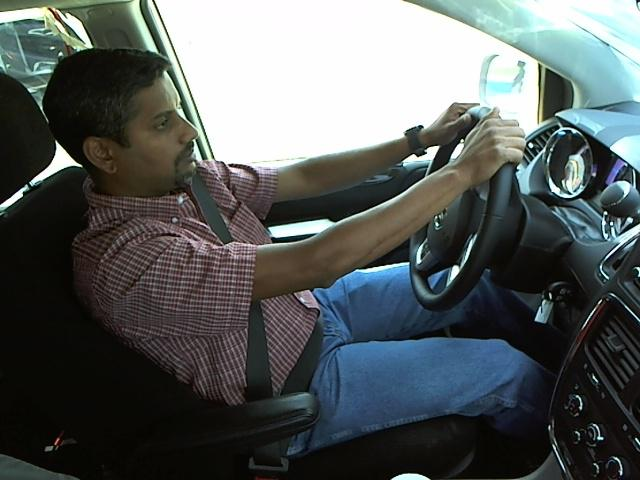

(1, 96, 96, 1)


'Talking to passenger'

In [110]:
img = cv2.imread("data/imgs/train/c0/img_34.jpg")
display_array(img) 
img = preprocess_image(
    img, 
    advanced=False,
    do_line_detection=False,
    image_shape=(96,96),
    flatten=False
) 
img = norm(img, "default")



img = img.reshape([1] + list(img.shape) + [1]) 

print(img.shape)

#print(img..reshape(1, -1))
predict(img)

In [ ]:
img = cv2.resize(
        greyed_blured_and_line_detection( 
        cv2.imread("data/imgs/test/img_2.jpg"), 
            advanced=True,
            do_line_detection=False
    ),
    (96, 96)
)

display_array(
    img
) 
predict(img.flatten().reshape(1, -1))

In [ ]:
img = cv2.resize(
        greyed_blured_and_line_detection( 
        cv2.imread("data/imgs/test/img_3.jpg"), 
            advanced=True,
            do_line_detection=False
    ),
    (96, 96)
)

display_array(
    img
) 
predict(img.flatten().reshape(1, -1))

In [ ]:
img = cv2.resize(
        greyed_blured_and_line_detection( 
        cv2.imread("data/imgs/test/img_4.jpg"), 
            advanced=True,
            do_line_detection=False
    ),
    (96, 96)
)

display_array(
    img
) 
predict(img.flatten().reshape(1, -1))

In [ ]:
img = cv2.resize(
        greyed_blured_and_line_detection( 
        cv2.imread("data/imgs/test/img_7.jpg"), 
            advanced=True,
            do_line_detection=False
    ),
    (96, 96)
)

display_array(
    img
) 
predict(img.flatten().reshape(1, -1))